# Autoencoder MNIST

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

import sys
import os

import numpy as np
from skimage import color, io

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.utils
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import FashionMNIST

In [5]:
print(torch.cuda.is_available())

False


### Training hyperparameters

In [2]:
latent_dims = 2   # Dimensiones del espacio latente
capacity = 16     # Cantidad de filtros de la primera capa

num_epochs = 50
batch_size = 128
learning_rate = 1e-3
use_gpu = True

### Fashion MNIST dataset

In [3]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # image = (image - mean) / std
])

train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


Extracting ./data/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw




Extracting ./data/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw




Extracting ./data/FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw




Extracting ./data/FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Autoencoder definition

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) 
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) 
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x)) 
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 24803


### Training loop

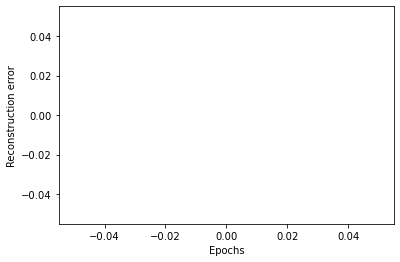

Training ...
Epoch [1 / 50] average reconstruction error: 0.191237
Epoch [2 / 50] average reconstruction error: 0.138373
Epoch [3 / 50] average reconstruction error: 0.133182
Epoch [4 / 50] average reconstruction error: 0.130021
Epoch [5 / 50] average reconstruction error: 0.127302
Epoch [6 / 50] average reconstruction error: 0.125241
Epoch [7 / 50] average reconstruction error: 0.123620
Epoch [8 / 50] average reconstruction error: 0.122437
Epoch [9 / 50] average reconstruction error: 0.121454
Epoch [10 / 50] average reconstruction error: 0.120735
Epoch [11 / 50] average reconstruction error: 0.120104
Epoch [12 / 50] average reconstruction error: 0.119652
Epoch [13 / 50] average reconstruction error: 0.119163
Epoch [14 / 50] average reconstruction error: 0.118691
Epoch [15 / 50] average reconstruction error: 0.118370
Epoch [16 / 50] average reconstruction error: 0.117936
Epoch [17 / 50] average reconstruction error: 0.117677


KeyboardInterrupt: 

In [5]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

autoencoder.train()

train_loss_avg = []

fig = plt.figure()
line, = plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

print('Training ...')
for epoch in range(num_epochs):
    
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)
        image_batch_recon = autoencoder(image_batch)
        
        loss = F.mse_loss(image_batch_recon, image_batch)
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    
    line.set_xdata(range(1, epoch+2))
    line.set_ydata(train_loss_avg)
    
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    